# Convolutional Neural Networks With BatchFlow

Now it's time to talk about convolutional neural networks and in this notebook you will find out how to do:
* data augmentation;
* early stopping.

In [1]:
import sys

import PIL
import numpy as np
from tqdm import tqdm

# the following line is not required if BatchFlow is installed as a python package.
sys.path.append('../..')
from batchflow import D, B, V, C, R, P
from batchflow.opensets import MNIST
from batchflow.models.tf import TFModel
from batchflow.models.torch import TorchModel
from batchflow.models.metrics import ClassificationMetrics
from batchflow.utils import plot_images, plot_loss

You don't need to implement a [MNIST](https://analysiscenter.github.io/batchflow/api/batchflow.opensets.html#mnist) dataset. It is already done for you.

In [2]:
mnist = MNIST()

We can use deep learning frameworks such as TensorFlow or PyTorch to make a neural network. These frameworks have a lot of differences under the hood. Batchflow allows us not to dive deep into each of them and use the same model configuration, thereby allowing us to build framework-agnostic models. 

But before,  we should define model class `'model'` and channels positions `'channels'` (for TensorFlow models - **'last'**, for PyTorch models - **'first'**) in ``config``. 

There are also predefined [models](https://analysiscenter.github.io/batchflow/intro/model_zoo.html) of both frameworks. You can use them without additional configuration.

## Model configuration

In [3]:
config = {
    'model': TorchModel,
    'channels': 'first'}
# or for TensorFlow model
# config = {
#     'model': TFModel,
#     'channels': 'last'}

As we already learned from the previous tutorials, first of all you have to define model configuration and create train and test pipelines. 

A little bit about the structure of batchflow model:
* **initial_block** - block containing the input layers;
* **body** - the main part of the model;
* **head** - outputs layers, like global average pooling or dense layers.

Let's create a dict with configuration for our model — ``model_config``. This dict is used when model is initialized. You can override default parameters or add new parameters by typing in a `model_config` key like **'body/layout'** and params to this key. Similar way use it in the key **'initial_block/inputs'** or **'head/units'**. 

The main parameter of each architecture is **'layout'**. It is a sequence of letters, each letter meaning operation. For example, operations in our model: 
 * c - convolution layer, 
 * b - batch normalization,
 * a - activation,
 * P - global pooling,
 * f - dense layer (fully connected).
 
In our configuration  **'body/filters'**, **'body/kernel_size'** are lists with a length equal to the number of convolutions, store individual parameters for each convolution. And **'body/strides'** is an integer — therefore, the same value is used for all convolutional layers.
 
In [docs](https://analysiscenter.github.io/batchflow/intro/tf_models.html#model-structure) you can read more.

In [4]:
model_config = {
    'inputs/images/shape': B.image_shape,
    'inputs/labels/classes': D.num_classes,
    'initial_block/inputs': 'images',
    'body': {'layout': 'cna cna cna', 
             'filters': [16, 32, 64], 
             'kernel_size': [7, 5, 3], 
             'strides': 2},
    'head': {'layout': 'Pf',
             'units': 10},
    'loss': 'ce',
    'optimizer': 'Adam',
    'output': dict(predicted=['proba', 'labels'])
}

## Train pipeline

We define our custom function for data augmentation.

In [5]:
def custom_filter(image, kernel_weights=None):
    """ Apply filter with custom kernel to image

    Parameters
    ----------
    kernel_weights: np.array
        Weights of kernel. 

    Returns
    -------
    filtered image """
    
    if kernel_weights is None:
        kernel_weights = np.ones((3,3))
        kernel_weights[1][1] = 10
        
    kernel = PIL.ImageFilter.Kernel(kernel_weights.shape, kernel_weights.ravel())
    
    return image.filter(kernel)

When config is defined, next step is to create a pipeline. Note that __rotate__ and __scale__ are methods of the __ImagesBatch__ class. You can see all avalible augmentations in [images tutorial](07_image_augmentation_examples.ipynb).

In contrast to them __apply_parallel__ is a function from __Batch__ class. It is worth mentioning because it runs our function `custom_filter` in parallel. About parallel method read [docs](https://analysiscenter.github.io/batchflow/intro/parallel.html).

In [6]:
train_pipeline = (
    mnist.train.p
    .init_variable('loss_history', default=[])
    .init_model('dynamic', C('model'), 'conv', config=model_config)
    .apply_parallel(custom_filter, src='images', p=0.8)
    .shift(offset=P(R('randint', 8, size=2)), p=0.8)
    .rotate(angle=P(R('uniform', -10, 10)), p=0.8)
    .scale(factor=P(R('uniform', 0.8, 1.2, size=R([1, 2]))), preserve_shape=True, p=0.8)
    .to_array(channels=C('channels'), dtype=np.float32)
    .multiply(multiplier=1/255)
    .train_model('conv', fetches='loss', images=B('images'), targets=B('labels'), 
                 save_to=V('loss_history', mode='a'))
) << config

## Validation pipeline

Testing on the augmented data

In [7]:
validation_pipeline = (
    mnist.test.p
    .init_variable('predictions')
    .init_variable('metrics', default=None)
    .import_model('conv', train_pipeline)
    .apply_parallel(custom_filter, src='images', p=0.8)
    .shift(offset=P(R('randint', 8, size=2)), p=0.8)
    .rotate(angle=P(R('uniform', -10, 10)), p=0.8)
    .scale(factor=P(R('uniform', 0.8, 1.2, size=R([1, 2]))), preserve_shape=True, p=0.8)
    .to_array(channels=C('channels'), dtype=np.float32)
    .multiply(multiplier=1/255)
    .predict_model('conv', images=B('images'),
                   fetches='predictions', save_to=V('predictions'))
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions'),
                    fmt='logits', axis=-1, save_to=V('metrics', mode='a'))
) << config

## Training process

We introduce an early stopping to terminate the model training when an average accuracy for a few last epochs will exceed 90 percent.

In [8]:
MAX_ITER = 500
FREQUENCY = N_LAST = 20
batch_size = 128

for curr_iter in tqdm(range(1, MAX_ITER + 1)):

    train_pipeline.next_batch(batch_size)
    validation_pipeline.next_batch(batch_size)

    if curr_iter % FREQUENCY == 0:
        metrics = validation_pipeline.v('metrics')
        accuracy = metrics[-N_LAST:].evaluate('accuracy')

        #Early stopping   
        if accuracy > 0.9:
            print('Early stop on {} iteration. Accuracy: {}'.format(curr_iter, accuracy))
            break

 44%|████▍     | 219/500 [00:38<00:41,  6.76it/s]

Early stop on 220 iteration. Accuracy: 0.907421875


Take a look at the loss history during training.

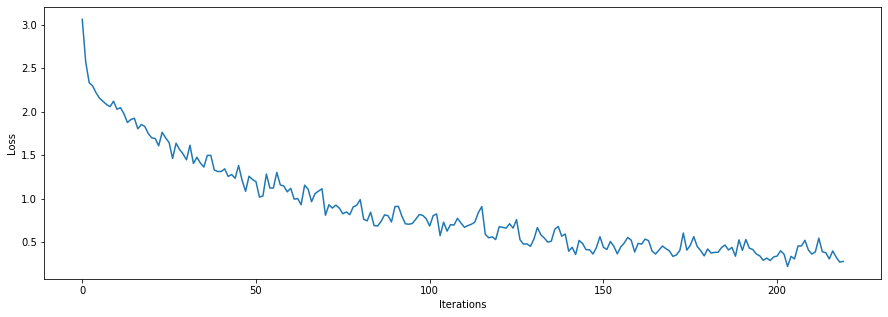

In [9]:
loss = train_pipeline.v('loss_history')
plot_loss(loss)

## Results

Our network is ready for inference. Now we don't use data augmentations. Let's take a look at the predictions.

In [10]:
inference_pipeline = (mnist.test.p
    .init_variables('proba', 'labels')
    .import_model('conv', train_pipeline) 
    .to_array(channels=C('channels'), dtype=np.float32)
    .multiply(multiplier=1/255)
    .predict_model('conv', images=B('images'),
        fetches=['predicted_proba', 'predicted_labels'],
        save_to=[V('proba'), V('labels')])) << config

It's always interesting to look at the images, so let's draw them.

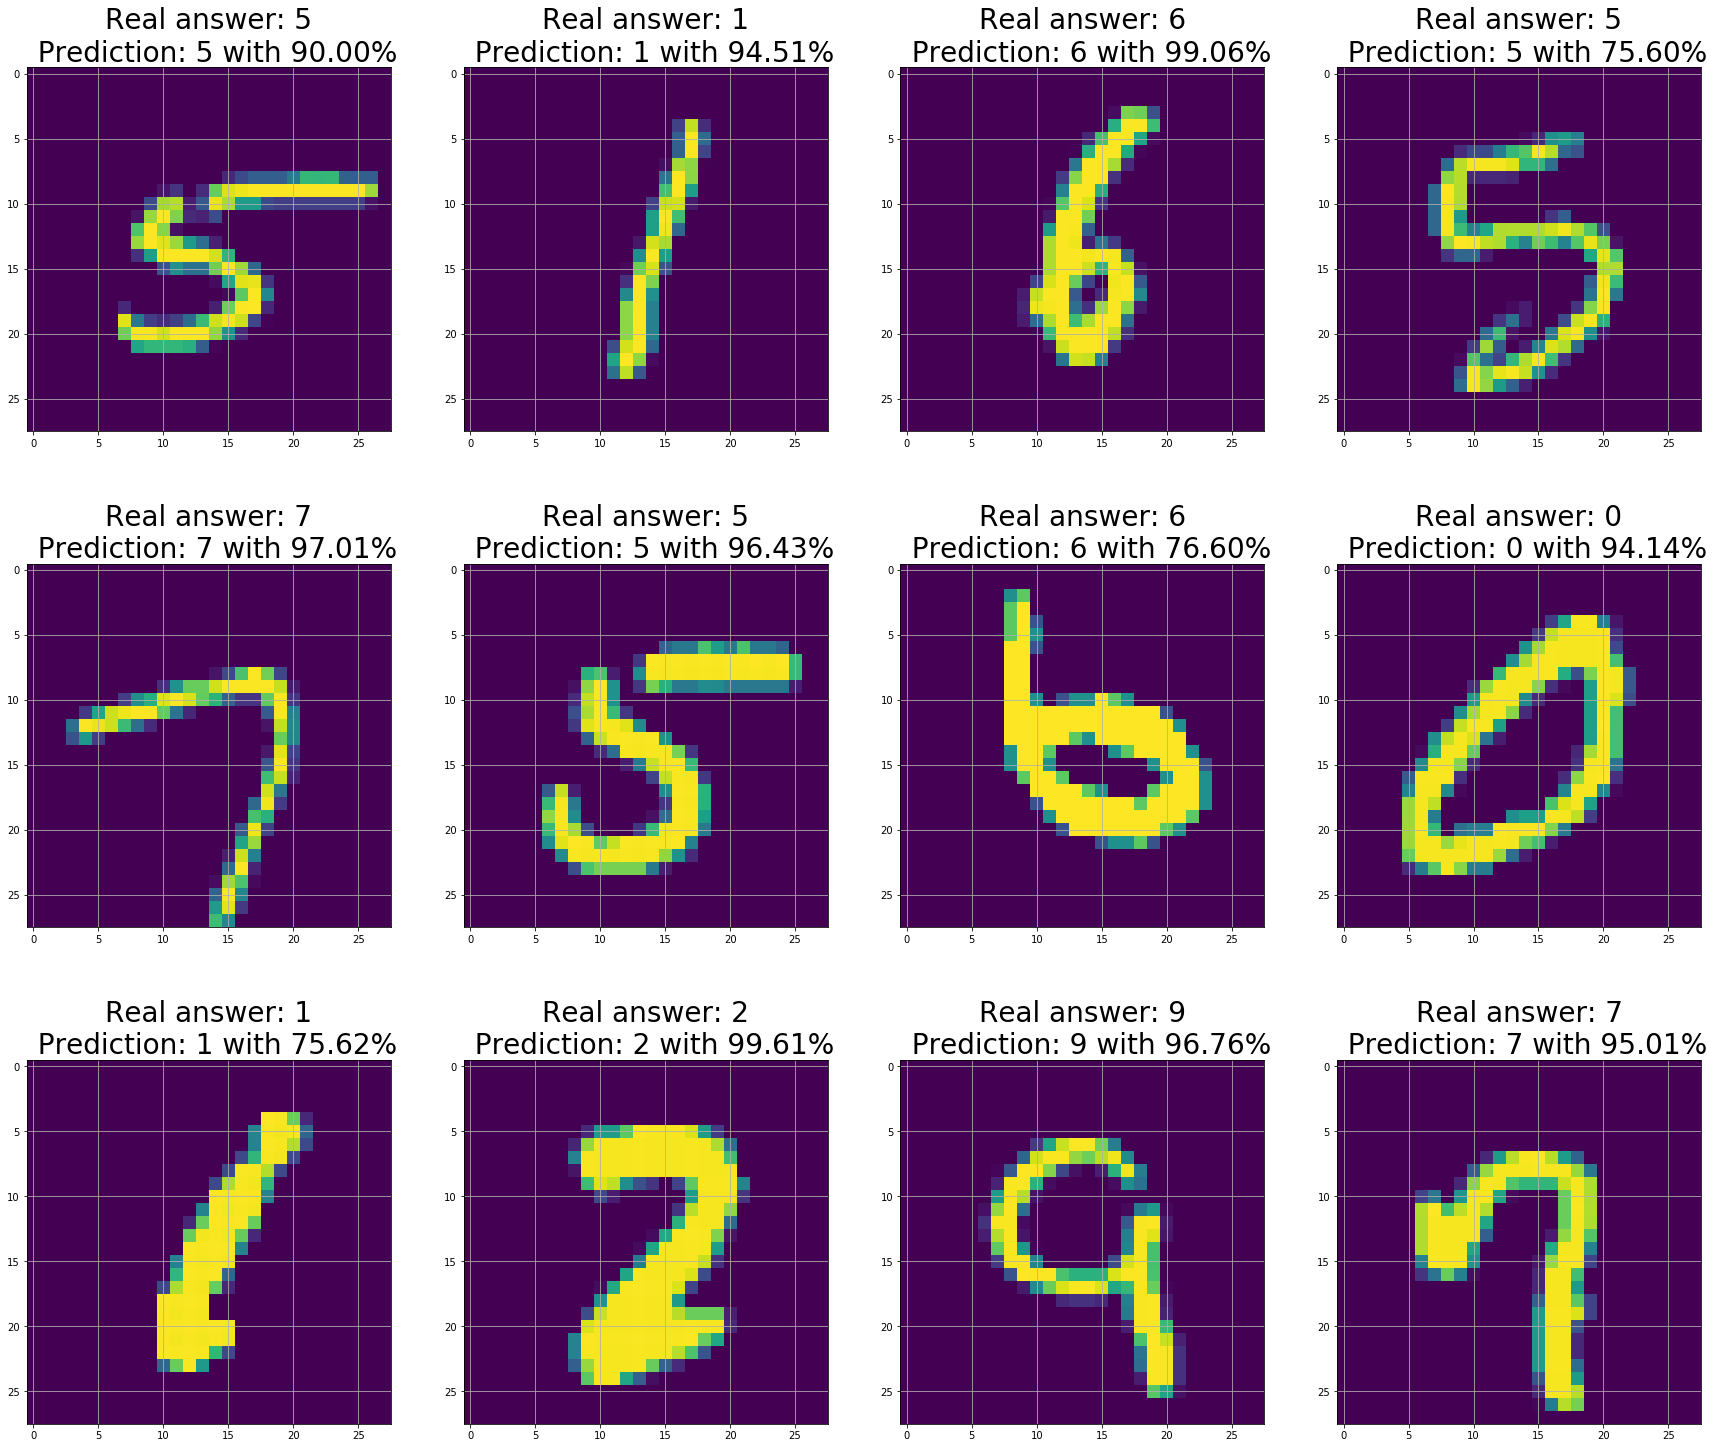

In [11]:
batch = inference_pipeline.next_batch(12, shuffle=True)

plot_images(np.squeeze(batch.images), batch.labels,
            batch.pipeline.v('proba'), ncols=4, figsize=(30, 35))

## Conclusion

Today you have learnt how to:
* create convolutional neural network with the BatchFlow.
* easily load MNIST data without writing your own loading functions.
* perforn data augmentation with dataset.
* configure the model using model config.

And found out that network can be more robust with data augmentations (like scale and rotate). 

## And what's next?
Because now you know how to work with convolutional models, you can:
* create a more sophisticated model
* change our model's config.

Your goal is 0.95 on the test data!

Good luck!

See [image augmentation tutorial](./06_image_augmentation.ipynb) for advanced augmentation methods or return to the [table of contents](./00_content.ipynb).